# Density Estimation with FFJORDs

Free-form Jacobian of Reversible Dynamics (FFJORD) is a continuous normalizing flow (CNF) variants proposed in [Grathwohl et al., 2018](https://arxiv.org/pdf/1810.01367.pdf). The core novelty is proposing utilization of stochastic trace estimators to improve scalability of the Jacobian trace computation ($$O(1)$$ calls to autograd instead of $$O(D)$$).

In [1]:
import sys

sys.path.append('..')
import torchdyn; from torchdyn.models import *; from torchdyn.datasets import *

This time, we use a fun dataset: the `DiffEqML` logo.

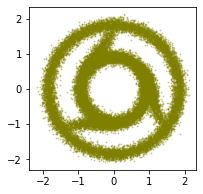

In [2]:
data = ToyDataset()
n_samples = 1 << 15
n_gaussians = 7

X, yn = data.generate(n_samples, 'diffeqml', noise=1e-1)
X = (X - X.mean())/X.std()

import matplotlib.pyplot as plt
plt.figure(figsize=(3, 3))
plt.scatter(X[:,0], X[:,1], c='olive', alpha=0.3, s=1)

In [3]:
import torch
import torch.utils.data as data
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
X_train = torch.Tensor(X).to(device)
train = data.TensorDataset(X_train)
trainloader = data.DataLoader(train, batch_size=1024, shuffle=True) 

## The FFJORD model

In `torchdyn`, we decouple CNFs from the Jacobian trace estimators they use. This allows us to easily implement variants without alternations to the original module. Indeed, we can simply define the Hutchinson stochastic estimator separately as follows

In [4]:
def hutch_trace(x_out, x_in, noise=None, **kwargs):
    """Hutchinson's trace Jacobian estimator, O(1) call to autograd"""
    jvp = torch.autograd.grad(x_out, x_in, noise, create_graph=True)[0]
    trJ = torch.einsum('bi,bi->b', jvp, noise) 
    return trJ

And then instantiate a CNF as before. 

In [5]:
# Galerkin variant of FFJORDs (not in any paper, yet :) )
# A small easter egg for sticking with torchdyn's tutorials!
f = nn.Sequential(
        nn.Linear(2, 64),
        nn.Softplus(),
        nn.Linear(64, 64),
        nn.Softplus(),
        nn.Linear(64, 2)
    )

from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform, Categorical
prior = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

# stochastic estimators require a definition of a distribution where "noise" vectors are sampled from
noise_dist = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))
# cnf wraps the net as with other energy models
cnf = CNF(f, trace_estimator=hutch_trace, noise_dist=noise_dist)
nde = NeuralDE(cnf, solver='dopri5', s_span=torch.linspace(0, 1, 2), sensitivity='adjoint', atol=1e-6, rtol=1e-6)

Augmenter takes care of setting up the additional scalar dimension for the divergence dynamics.
The `DEFunc` wrapper (implicitly defined when passing `f` to the NeuralDE) will ensure compatibility of depth-concatenation and data-control with the divergence dimension.

Utilizing additional augmented dimensions is also compatible, as only the first will be used for the jacobian trace.

In [6]:
model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=1),
                      nde).to(device)

Standard Learner. It is often useful to visualize samples during normalizing flow training, in order to identify issues quickly and stop runs that are not promising. For an example of how to log images using `PyTorch Lightning` and `Wandb`, refer to torchdyn's `benchmark` notebooks.

In [7]:
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.iters = 0
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        self.iters += 1 
        x = batch[0] ; x += 1e-2*torch.randn_like(x).to(x) # augment data with noise
        xtrJ = self.model(x)  
        logprob = prior.log_prob(xtrJ[:,1:]).to(x) - xtrJ[:,0] # logp(z_S) = logp(z_0) - \int_0^S trJ
        loss = -torch.mean(logprob)
        nde.nfe = 0
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=3e-3, weight_decay=5e-6)

    def train_dataloader(self):
        return trainloader

In [8]:
learn = Learner(model)
trainer = pl.Trainer(min_steps=15000)
trainer.fit(learn);

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 4 K   


C:\Users\Stefano\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:24: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


In [12]:
model.load_state_dict(torch.load('ffjord_diffeq'))

<All keys matched successfully>

Sampling from CNFs is easy: we query the prior latent normal and then pass the samples through the `z -> x` CNF flow. To reverse the flow, we flip `s_span`:

In [13]:
sample = prior.sample(torch.Size([1 << 10]))
# integrating from 1 to 0
model[1].s_span = torch.linspace(1, 0, 100)
new_x = model(sample).cpu().detach()

We then plot, samples, flows and density like so:

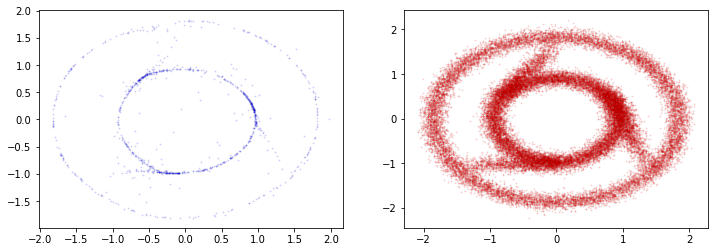

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(new_x[:,1], new_x[:,2], s=2.3, alpha=0.2, linewidths=0.1, c='blue', edgecolors='black')

plt.subplot(122)
plt.scatter(X[:,0], X[:,1], s=2.3, alpha=0.2, c='red',  linewidths=0.1, edgecolors='black')

We plot the flows from prior to data distribution:

In [19]:
sample = prior.sample(torch.Size([1 << 15]))
print(sample.shape)
x0, s_span = Augmenter(1, 1)(sample.to(device)), torch.linspace(1,0,100)
traj = model[1].trajectory(x0, s_span).detach().cpu()
            
sample = sample.cpu()
traj = traj[:, :, 1:] # scrapping first dimension := jacobian trace

torch.Size([32768, 2])


In [20]:
import matplotlib
from matplotlib import cm
import numpy as np
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, alpha=1**kwargs ):
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
    z[np.where(np.isnan(z))] = 0.0
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    cmap = matplotlib.cm.inferno
    ax.scatter( x, y, c=z, **kwargs , s=1, cmap=cmap, rasterized=True, alpha=alpha)
    ax.set_facecolor(cmap(0.))    
    ax.set_xlim([-2,2]) ; ax.set_ylim([-2,2])
    ax.set_xticks([]) ; ax.set_yticks([])
    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    return ax

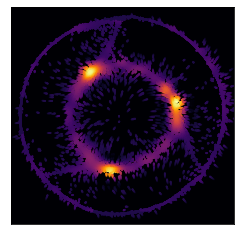

In [30]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

d=2
i = 0
tail = 10
for i in range(traj.shape[0]):
    ax.cla()
    if i==0:
        density_scatter(traj[0,::d,0].numpy(),traj[0,::d,1].numpy(), ax)
    elif i<tail:
        j = i
        while j>=0:
            density_scatter(traj[i-j,::d,0].numpy(),traj[i-j,::d,1].numpy(), ax, alpha=(i+1 - j)/i)
            j -= 1
    else:
        j = tail
        while j>=0:
            density_scatter(traj[i-j,::d,0].numpy(),traj[i-j,::d,1].numpy(), ax, alpha=(tail+1 - j)/tail)
            j -= 1
        
    plt.savefig("tmp/ffjord%04d.png" % i,dpi=300)

In [ ]:
# to create the video execute the following command in your shell
# ffmpeg -r 20 -f image2 -i tmp/ffjord%04d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p test.mp4